<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff355e;'>📑 Styling, Links and Modules</h1>

---

#### [🌐 tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras)
#### [🌐 The Data Set of Flower Images (R)](https://www.kaggle.com/olgabelitskaya/the-data-set-of-flower-images-r) & [🌐 Github Repository](https://github.com/OlgaBelitskaya/deep_learning_projects/tree/master/DL_PP0) & [🌐 Google Colaboratory Version](https://colab.research.google.com/drive/1H2ArWH_1kYfkIoCbxleX-aHAozRVBAdB)

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Ewert|Roboto&effect=3d'); 
a,h4 {color:slategray; font-family:Roboto; text-shadow:3px 3px 3px #aaa;}
span {color:black; font-family:Roboto; text-shadow:3px 3px 3px #aaa;}
div.output_prompt,div.output_area pre {color:slategray;}
div.input_prompt,div.output_subarea {color:#ff355e;}      
div.output_stderr pre {background-color:gainsboro;}  
div.output_stderr {background-color:slategrey;}     
</style>

In [2]:
import warnings; warnings.filterwarnings('ignore')
import tensorflow as tf,seaborn as sn,pylab as pl
import os,h5py,cv2,pandas as pd,numpy as np
from tensorflow import keras as tk
import keras.preprocessing.image as tkimg
from keras.callbacks import \
ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import \
BatchNormalization,Conv2D,Dense,\
LSTM,Flatten,Activation,Dropout,MaxPooling2D,\
GlobalMaxPooling2D,GlobalAveragePooling2D
from keras.layers.advanced_activations \
import PReLU,LeakyReLU
fpaths='../input/flower-color-images/'+\
       'flower_images/flower_images/'
fpaths2='../input/flower-color-images/'
fweights='/checkpoints'
print('tensorflow version:',tf.__version__)

Using TensorFlow backend.


tensorflow version: 1.7.0


In [3]:
def images2array(files_path,img_size,grayscale=False):
    files_list=sorted(os.listdir(files_path))
    n,img_array=len(files_list),[]
    for i in range(n):
        if i%round(.1*n)==0:
            print('=>',end='',flush=True)
        img_path=files_path+files_list[i]
        if (img_path[-4:]=='.png'):
            img=tkimg.load_img(
                img_path,grayscale=grayscale,
                target_size=(img_size,img_size))
        img=tkimg.img_to_array(np.squeeze(img))
        img=np.expand_dims(img,axis=0)/255
        img_array.append(img)
    return np.array(np.vstack(img_array),dtype='float32')
def keras_history_plot(fit_history,fig_size,color='#ff355e'):
    keys=list(fit_history.history.keys())
    list_history=[fit_history.history[keys[i]] 
                  for i in range(len(keys))]
    dfkeys=pd.DataFrame(list_history).T
    dfkeys.columns=keys
    fig=pl.figure(figsize=(fig_size,fig_size))
    ax1=fig.add_subplot(2,1,1)
    dfkeys.iloc[:,[0,2]].plot(
        ax=ax1,color=['slategray',color],grid=True)
    ax2=fig.add_subplot(2,1,2)
    dfkeys.iloc[:,[1,3]].plot(
        ax=ax2,color=['slategray',color],grid=True)
    pl.tight_layout(); pl.show()

<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff355e;'>📑 Data Exploration</h1>

In [4]:
flowers=pd.read_csv(fpaths+'flower_labels.csv')
files=flowers['file']
labels=np.array(flowers['label'].values,dtype='int32')
names=['phlox','rose','calendula','iris',
       'max chrysanthemum','bellflower','viola',
       'rudbeckia laciniata','peony','aquilegia']
img_size=128
images=images2array(fpaths,img_size)
with h5py.File(fpaths2+'FlowerColorImages.h5','r') as f:
    images2=f['images'].value
    labels2=f['labels'].value

=>=>=>=>=>=>=>=>=>=>=>

In [5]:
N=labels.shape[0]; n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images,labels=images[shuffle_ids],labels[shuffle_ids]
x_test,x_valid,x_train=\
images[:n],images[n:2*n],images[2*n:]
y_test,y_valid,y_train=\
labels[:n],labels[n:2*n],labels[2*n:]
df=pd.DataFrame(
    [[x_train.shape,x_valid.shape,x_test.shape],
     [x_train.dtype,x_valid.dtype,x_test.dtype],
     [y_train.shape,y_valid.shape,y_test.shape],
     [y_train.dtype,y_valid.dtype,y_test.dtype]],
    columns=['train','valid','test'],
    index=['image shape','image type',
           'label shape','label type'])
df

,train,valid,test
image shape,"(168, 128, 128, 3)","(21, 128, 128, 3)","(21, 128, 128, 3)"
image type,float32,float32,float32
label shape,"(168,)","(21,)","(21,)"
label type,int32,int32,int32


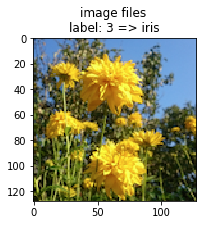

In [6]:
n=np.random.randint(0,210,1)[0]
ti='image files \nlabel: %d => '\
%labels[n]+names[labels[n]]
img=cv2.imread(fpaths+files[n])
rgb_img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
pl.figure(figsize=(3,3))
pl.imshow(rgb_img); pl.title(ti);

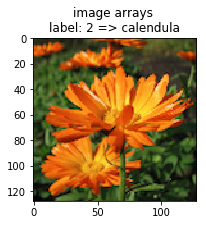

In [7]:
n=np.random.randint(0,167,1)[0]
ti='image arrays \nlabel: %d => '\
%y_train[n]+names[y_train[n]]
pl.figure(figsize=(3,3))
pl.imshow((x_train[n])); pl.title(ti);

<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff355e;'>📑 Classification Models</h1>

In [8]:
def mlp_model():
    model=Sequential()    
    model.add(Dense(
        128,activation='relu',input_shape=(img_size**2*3,)))
    model.add(BatchNormalization())    
    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())    
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())   
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(.2))     
    model.add(Dense(10,activation='softmax'))
    model.compile(optimizer='adam',metrics=['accuracy'],
                  loss='sparse_categorical_crossentropy')
    return model
mlp_model=mlp_model()

In [9]:
early_stopping=EarlyStopping(
    monitor='val_loss',patience=20,verbose=2)
checkpointer=ModelCheckpoint(
    filepath=fweights,save_best_only=True,verbose=2,
    save_weights_only=True,monitor='val_acc',mode='max')
lr_reduction=ReduceLROnPlateau(
    monitor='val_loss',verbose=2,patience=5,factor=.8)
history=mlp_model.fit(
    x_train.reshape(-1,img_size**2*3),y_train,
    epochs=100,batch_size=64,verbose=2,
    validation_data=(x_valid.reshape(-1,img_size**2*3),y_valid),
    callbacks=[checkpointer,early_stopping,lr_reduction])

Train on 168 samples, validate on 21 samples
Epoch 1/100
 - 2s - loss: 2.4040 - acc: 0.1845 - val_loss: 14.4155 - val_acc: 0.0476

Epoch 00001: val_acc improved from -inf to 0.04762, saving model to /checkpoints
Epoch 2/100
 - 0s - loss: 1.1414 - acc: 0.6429 - val_loss: 4.3303 - val_acc: 0.1905

Epoch 00002: val_acc improved from 0.04762 to 0.19048, saving model to /checkpoints
Epoch 3/100
 - 0s - loss: 0.5639 - acc: 0.8274 - val_loss: 4.0244 - val_acc: 0.2857

Epoch 00003: val_acc improved from 0.19048 to 0.28571, saving model to /checkpoints
Epoch 4/100
 - 0s - loss: 0.3065 - acc: 0.9167 - val_loss: 2.7601 - val_acc: 0.1905

Epoch 00004: val_acc did not improve
Epoch 5/100
 - 0s - loss: 0.1634 - acc: 0.9524 - val_loss: 3.2793 - val_acc: 0.2381

Epoch 00005: val_acc did not improve
Epoch 6/100
 - 0s - loss: 0.0828 - acc: 0.9940 - val_loss: 3.3135 - val_acc: 0.2381

Epoch 00006: val_acc did not improve
Epoch 7/100
 - 0s - loss: 0.0459 - acc: 0.9940 - val_loss: 3.6511 - val_acc: 0.2857


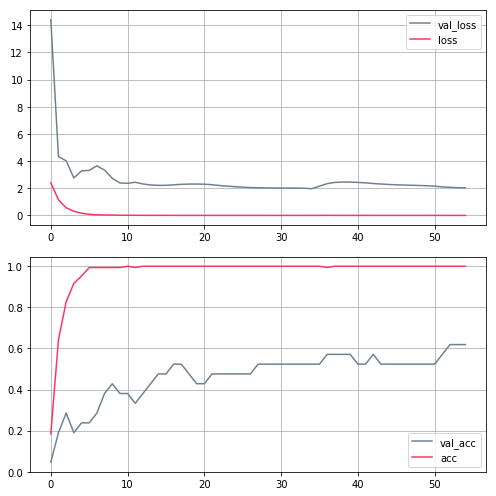

[1.5009422302246094, 0.6666666865348816]

In [10]:
keras_history_plot(history,7)
mlp_model.load_weights(fweights)
mlp_model.evaluate(
    x_test.reshape(-1,img_size**2*3),y_test,verbose=0)

In [11]:
def cnn_model():
    model=Sequential()
    model.add(Conv2D(32,(5,5),padding='same',
                     input_shape=(img_size,img_size,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.25))
    model.add(Conv2D(96,(5,5)))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.25))
    model.add(GlobalAveragePooling2D())    
    model.add(Dense(512,activation='tanh'))
    model.add(Dropout(.25))     
#    model.add(Dense(256,activation='tanh'))
#    model.add(Dropout(.25))     
    model.add(Dense(128,activation='tanh'))
    model.add(Dropout(.25)) 
    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])    
    return model
cnn_model=cnn_model()

In [12]:
early_stopping=EarlyStopping(
    monitor='val_loss',patience=20,verbose=2)
checkpointer=ModelCheckpoint(
    filepath=fweights,save_best_only=True,verbose=2,
    save_weights_only=True,monitor='val_acc',mode='max')
lr_reduction=ReduceLROnPlateau(
    monitor='val_loss',verbose=2,patience=5,factor=.8)
history=cnn_model.fit(
    x_train,y_train,epochs=100,batch_size=16,
    verbose=2,validation_data=(x_valid,y_valid),
    callbacks=[checkpointer,early_stopping,lr_reduction])

Train on 168 samples, validate on 21 samples
Epoch 1/100
 - 9s - loss: 2.3357 - acc: 0.1369 - val_loss: 2.2428 - val_acc: 0.1905

Epoch 00001: val_acc improved from -inf to 0.19048, saving model to /checkpoints
Epoch 2/100
 - 8s - loss: 2.2507 - acc: 0.1607 - val_loss: 2.0649 - val_acc: 0.2857

Epoch 00002: val_acc improved from 0.19048 to 0.28571, saving model to /checkpoints
Epoch 3/100
 - 8s - loss: 2.0164 - acc: 0.2917 - val_loss: 1.9155 - val_acc: 0.1905

Epoch 00003: val_acc did not improve
Epoch 4/100
 - 8s - loss: 1.7824 - acc: 0.3274 - val_loss: 1.8240 - val_acc: 0.3810

Epoch 00004: val_acc improved from 0.28571 to 0.38095, saving model to /checkpoints
Epoch 5/100
 - 8s - loss: 1.6582 - acc: 0.3929 - val_loss: 1.6721 - val_acc: 0.3810

Epoch 00005: val_acc did not improve
Epoch 6/100
 - 8s - loss: 1.5207 - acc: 0.4643 - val_loss: 1.8244 - val_acc: 0.2857

Epoch 00006: val_acc did not improve
Epoch 7/100
 - 9s - loss: 1.5034 - acc: 0.4345 - val_loss: 1.2806 - val_acc: 0.4286



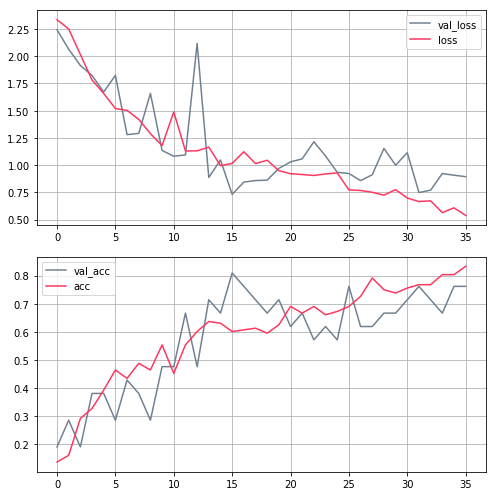

[1.5766324996948242, 0.4285714328289032]

In [13]:
keras_history_plot(history,7)
cnn_model.load_weights(fweights)
cnn_model.evaluate(x_test,y_test,verbose=0)

In [14]:
generator=tkimg.\
ImageDataGenerator(shear_range=.3,zoom_range=.3,
                   rotation_range=30,horizontal_flip=True)
ghistory=cnn_model.fit_generator(generator\
.flow(x_train,y_train,batch_size=16),\
steps_per_epoch=11,epochs=10,verbose=2,\
validation_data=(x_valid,y_valid),
callbacks=[checkpointer,early_stopping,lr_reduction])

Epoch 1/10
 - 9s - loss: 0.9604 - acc: 0.6820 - val_loss: 0.8342 - val_acc: 0.6667

Epoch 00001: val_acc did not improve
Epoch 2/10
 - 9s - loss: 0.9592 - acc: 0.6815 - val_loss: 0.8173 - val_acc: 0.7619

Epoch 00002: val_acc did not improve
Epoch 3/10
 - 8s - loss: 0.8935 - acc: 0.6811 - val_loss: 0.9268 - val_acc: 0.6667

Epoch 00003: val_acc did not improve
Epoch 4/10
 - 9s - loss: 0.8929 - acc: 0.7059 - val_loss: 0.9210 - val_acc: 0.7143

Epoch 00004: val_acc did not improve
Epoch 5/10
 - 9s - loss: 0.8418 - acc: 0.7448 - val_loss: 0.7623 - val_acc: 0.6667

Epoch 00005: val_acc did not improve
Epoch 6/10
 - 9s - loss: 0.8303 - acc: 0.7339 - val_loss: 0.9438 - val_acc: 0.7619

Epoch 00006: val_acc did not improve
Epoch 7/10
 - 8s - loss: 0.8335 - acc: 0.7153 - val_loss: 0.8863 - val_acc: 0.6667

Epoch 00007: val_acc did not improve
Epoch 8/10
 - 9s - loss: 0.8457 - acc: 0.6877 - val_loss: 0.8361 - val_acc: 0.7143

Epoch 00008: val_acc did not improve
Epoch 9/10
 - 8s - loss: 0.7996 

In [15]:
cnn_model.load_weights(fweights)
cnn_model.evaluate(x_test,y_test,verbose=0)

[1.5766324996948242, 0.4285714328289032]

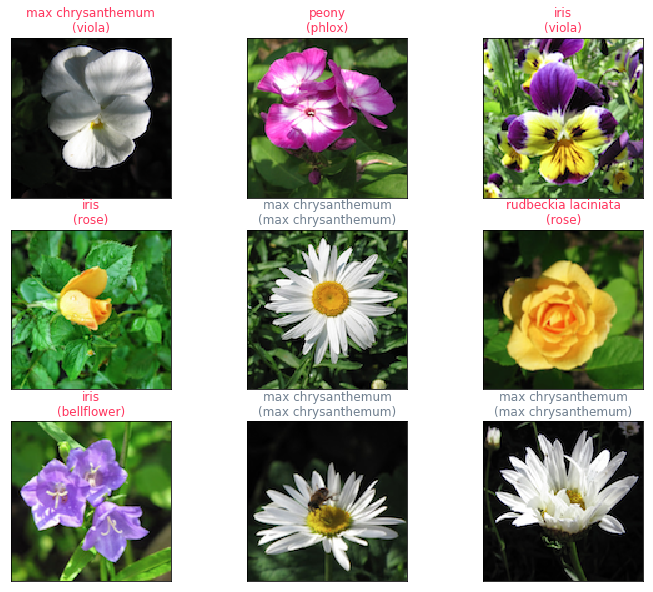

In [16]:
py_test_cnn=cnn_model.predict_classes(x_test)
fig=pl.figure(figsize=(12,10))
randch=np.random.choice(
    x_test.shape[0],size=9,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(3,3,i+1,xticks=[],yticks=[])
    ax.imshow(x_test[idx])
    pred_idx=py_test_cnn[idx]
    true_idx=y_test[idx]
    ti='{}\n({})'.format(names[pred_idx],names[true_idx])
    ax.set_title(ti,color=(
        'slategray' if pred_idx==true_idx else '#ff355e'))
pl.show()

In [17]:
def rnn_model():
    model=Sequential()
    model.add(LSTM(196,return_sequences=True,
                   input_shape=(1,img_size**2*3))) 
    model.add(LSTM(196,return_sequences=True))
    model.add(LSTM(196))  
    model.add(Dense(512,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])    
    return model
rnn_model=rnn_model()

In [18]:
early_stopping=EarlyStopping(
    monitor='val_loss',patience=20,verbose=2)
checkpointer=ModelCheckpoint(
    filepath=fweights,save_best_only=True,verbose=2,
    save_weights_only=True,monitor='val_acc',mode='max')
lr_reduction=ReduceLROnPlateau(
    monitor='val_loss',verbose=2,patience=5,factor=.8)
history=rnn_model.fit(
    x_train.reshape(-1,1,img_size**2*3),y_train,
    epochs=100,batch_size=64,verbose=2,
    validation_data=(x_valid.reshape(-1,1,img_size**2*3),y_valid),
    callbacks=[checkpointer,early_stopping,lr_reduction])

Train on 168 samples, validate on 21 samples
Epoch 1/100
 - 8s - loss: 2.3042 - acc: 0.0595 - val_loss: 2.2999 - val_acc: 0.0952

Epoch 00001: val_acc improved from -inf to 0.09524, saving model to /checkpoints
Epoch 2/100
 - 4s - loss: 2.2971 - acc: 0.1250 - val_loss: 2.2925 - val_acc: 0.0952

Epoch 00002: val_acc did not improve
Epoch 3/100
 - 3s - loss: 2.2858 - acc: 0.1250 - val_loss: 2.2821 - val_acc: 0.0952

Epoch 00003: val_acc did not improve
Epoch 4/100
 - 3s - loss: 2.2730 - acc: 0.1250 - val_loss: 2.2685 - val_acc: 0.0952

Epoch 00004: val_acc did not improve
Epoch 5/100
 - 3s - loss: 2.2517 - acc: 0.1726 - val_loss: 2.2386 - val_acc: 0.1429

Epoch 00005: val_acc improved from 0.09524 to 0.14286, saving model to /checkpoints
Epoch 6/100
 - 3s - loss: 2.2126 - acc: 0.1369 - val_loss: 2.1838 - val_acc: 0.1905

Epoch 00006: val_acc improved from 0.14286 to 0.19048, saving model to /checkpoints
Epoch 7/100
 - 3s - loss: 2.1420 - acc: 0.2083 - val_loss: 2.0768 - val_acc: 0.1429



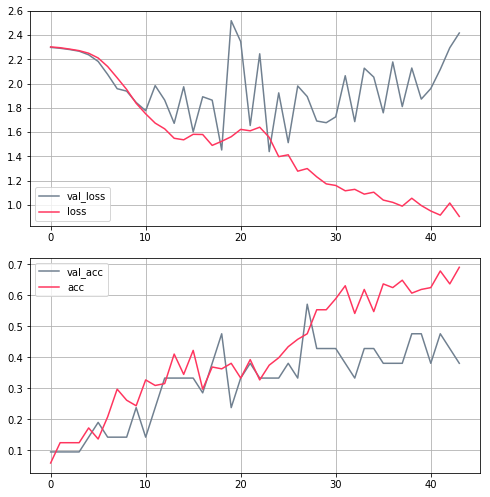

[2.096680164337158, 0.3333333432674408]

In [19]:
keras_history_plot(history,7)
rnn_model.load_weights(fweights)
rnn_model.evaluate(
    x_test.reshape(-1,1,img_size**2*3),y_test,verbose=0)